# Práctica 8: Análisis de varianza y de componentes principales
## Gabriela Sánchez Y.

El objetivo de la práctica es llevar a cabo un análisis de varianza (ANOVA) y un análisis de componentes principales (PCA) a los datos con los que se ha estado trabajando, visualizar los resultados y discutirlos.

La variable de interés es la cantidad de incidentes de violencia familiar, ya que se desea encontrar al grupo más vulnerable.

Se ha realizado un preprocesamiento de los datos para incluir solamente algunas caraterísticas de las víctimas tales como la edad, el estado civil, escolaridad, hora, mes y lugar donde ocurrió el indicente y el parentesco de la víctima con el agresor. Se han eliminado los incidentes para los cuales no se especifica alguno de los datos antes mencionados.

In [1]:
import pandas as pd
pd.set_option('max_rows', 10)

datos = pd.read_csv("victimas.csv")
datos = datos.drop('Unnamed: 0',1)
datos

,edad,edo_civil,escolaridad,hora,mes,mpio,parentesco,cuantos
0,46,CASADO,SECUNDARIA,N,1,CADEREYTA JIMÉNEZ,UL,1
1,26,CASADO,SECUNDARIA,M,1,CADEREYTA JIMÉNEZ,CONCUBINO,1
2,42,CASADO,PREPARATORIA,M,1,CADEREYTA JIMÉNEZ,NINGUNO,1
3,26,CASADO,PREPARATORIA,M,1,CIÉNEGA DE FLORES,CONCUBINO,1
4,38,CASADO,SECUNDARIA,T,1,CIÉNEGA DE FLORES,ESPOSO,1
...,...,...,...,...,...,...,...,...
17036,48,CASADO,PRIMARIA,M,12,SALINAS VICTORIA,NINGUNO,1
17037,32,CASADO,PREPARATORIA,N,12,SALINAS VICTORIA,NINGUNO,1
17038,21,CASADO,PREPARATORIA,M,12,SALINAS VICTORIA,CONCUBINO,1
17039,32,CASADO,SECUNDARIA,T,12,SALINAS VICTORIA,ESPOSO,1


In [2]:
datos.escolaridad.unique()

array(['SECUNDARIA', 'PREPARATORIA', 'PRIMARIA', 'NINGUNO',
       'LICENCIATURA', 'TÉCNICO', 'POSGRADO'], dtype=object)

Para no trabajar con tantos niveles, se agrupan las edades en bloques de 10.

In [3]:
datos.edad = [0 if (v >= 0 and v <= 9) else 1 if (v >= 10 and v <= 19) else 2 if (v >= 20 and v <= 29)
             else 3 if (v >= 30 and v <= 39) else 4 if (v >= 40 and v <= 49) else 5 if (v >= 50 and v <= 59)
             else 6 if (v >= 60 and v <= 69) else 7 if (v >= 70 and v <= 79) else 8 if (v >= 80 and v <= 89)
             else 9 for v in datos.edad]

datos.escolaridad = [0 if v == "NINGUNO" else 1 if v == "PRIMARIA" else 2 if v == "SECUNDARIA"
                     else 3 if v == "PREPARATORIA" else 4 if v == "TÉCNICO" else 5 if v == "LICENCIATURA"
                     else 6 for v in [str(v) for v in datos.escolaridad]]


In [4]:
datos.hora.replace(to_replace = dict(M = 0, T = 1, N = 2), inplace = True)
datos.edo_civil.replace(to_replace = dict(SOLTERO = 0, CASADO = 1), inplace = True)

datos['hora'] = [int(t) for t in datos.hora]
datos['edo_civil'] = [int(t) for t in datos.edo_civil]
datos['escolaridad'] = [int(t) for t in datos.escolaridad]

c = datos.groupby(['edad', 'edo_civil', 'escolaridad', 'hora', 'mes'], as_index=False).agg({"cuantos": "sum"})

Los datos no son balanceados. Se prueba un primer modelo con un ANOVA tipo 2, en el cual no se consideran interacciones entre los distintos factores.

In [5]:
import statsmodels.api as sm
from statsmodels.formula.api import ols
import ssl

if getattr(ssl, '_create_unverified_context', None):
    ssl._create_default_https_context = ssl._create_unverified_context

m = ols('cuantos ~ edad + edo_civil + escolaridad + hora + mes', data = c).fit() 
a = sm.stats.anova_lm(m, typ = 2)

print(a)
n = len(a)
alpha = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a.index[i], "" if a['PR(>F)'][i] < alpha else "NO "))

                    sum_sq      df           F        PR(>F)
edad          28103.315009     1.0  213.730001  2.858234e-46
edo_civil     30232.123042     1.0  229.919911  1.767271e-49
escolaridad    5895.187520     1.0   44.833801  2.712031e-11
hora           3115.409120     1.0   23.693162  1.209809e-06
mes             140.921029     1.0    1.071726  3.006693e-01
Residual     290197.987725  2207.0         NaN           NaN
edad es significativo
edo_civil es significativo
escolaridad es significativo
hora es significativo
mes NO es significativo
Residual NO es significativo


/usr/local/lib/python3.5/dist-packages/pandas/core/computation/check.py:19: UserWarning: The installed version of numexpr 2.4.3 is not supported in pandas and will be not be used
The minimum supported version is 2.6.1

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


Parece ser que casi todos los factores son significativos para la variable de interés. Sin embargo, el modelo tiene algunos residules son muy altos. Habrá que intentar otra cosa.

La siguiente prueba incluye interacciones entre los factores.

In [6]:
m = ols('cuantos ~ edad * edo_civil + edad * hora + edad * escolaridad', data = c).fit() 
a = sm.stats.anova_lm(m, typ = 2)
print(a)
n = len(a)
alpha = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a.index[i], "" if a['PR(>F)'][i] < alpha else "NO "))

                         sum_sq      df           F        PR(>F)
edad               28047.938691     1.0  218.876307  2.726351e-47
edo_civil          30247.078317     1.0  236.037623  1.103524e-50
edad:edo_civil      6916.724660     1.0   53.975701  2.843324e-13
hora                3020.502432     1.0   23.570945  1.288347e-06
edad:hora            645.207120     1.0    5.034971  2.493937e-02
escolaridad         6346.876698     1.0   49.528807  2.599533e-12
edad:escolaridad     500.301989     1.0    3.904182  4.829056e-02
Residual          282560.071260  2205.0         NaN           NaN
edad es significativo
edo_civil es significativo
edad:edo_civil es significativo
hora es significativo
edad:hora es significativo
escolaridad es significativo
edad:escolaridad es significativo
Residual NO es significativo


Los residuales siguen altos. Se revisan otras interacciones.

In [7]:
m = ols('cuantos ~ edo_civil * hora + edo_civil * escolaridad + hora * escolaridad', data = c).fit() 
a = sm.stats.anova_lm(m, typ = 2)
print(a)
n = len(a)
alpha = 0.05
for i in range(n):
    print("{:s} {:s}es significativo".format(a.index[i], "" if a['PR(>F)'][i] < alpha else "NO "))

                              sum_sq      df           F        PR(>F)
edo_civil               25510.639510     1.0  177.684314  4.819435e-39
hora                     4042.701514     1.0   28.157845  1.229997e-07
edo_civil:hora           1177.105137     1.0    8.198662  4.231717e-03
escolaridad              5619.332279     1.0   39.139246  4.725898e-10
edo_civil:escolaridad     398.412854     1.0    2.774988  9.588936e-02
hora:escolaridad          105.131678     1.0    0.732253  3.922467e-01
Residual               316721.659781  2206.0         NaN           NaN
edo_civil es significativo
hora es significativo
edo_civil:hora es significativo
escolaridad es significativo
edo_civil:escolaridad NO es significativo
hora:escolaridad NO es significativo
Residual NO es significativo


De acuerdo a los modelos anteriores los factores de edad, estado civil, escolaridad y hora de los incidentes influyen en la varible de interés. Así como también influye la interacción entre algunos de ellos. Aunque aún hay mucha variación por explicar.

El siguiente paso es realizar un análisis de componentes principales. Para este análisis se consideran los factores de edad, mes, hora, escolaridad y edo_civil. Previamente estos datos se han modificado para tener datos numéricos.

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,comp_0,comp_1,hora
0,0.257331,2.357384,0
1,0.498128,2.371462,0
2,0.320782,2.384512,0
3,0.681049,2.398883,0
4,0.862112,2.412814,0


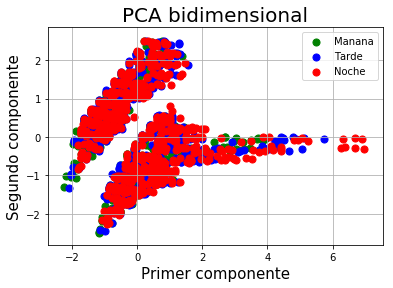

In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

features = ['cuantos', 'edad', 'escolaridad', 'edo_civil', 'mes']
x = c.loc[:, features].values
y = c.loc[:,['hora']].values
x = StandardScaler().fit_transform(x)
k=2
pca = PCA(n_components = 2)
cd = pd.DataFrame(data = pca.fit_transform(x), columns = ['comp_{:d}'.format(i) for i in range(k)])
cd['hora'] = y
display(cd.head(5))

pri = cd.hora == 0
seg = cd.hora == 1
ter = cd.hora == 2

plt.title('PCA bidimensional', fontsize = 20)
plt.xlabel('Primer componente', fontsize = 15)
plt.ylabel('Segundo componente', fontsize = 15)
plt.scatter(cd.loc[pri].comp_0, cd.loc[pri].comp_1, c = 'g', s = 50)
plt.scatter(cd.loc[seg].comp_0, cd.loc[seg].comp_1, c = 'b', s = 50)
plt.scatter(cd.loc[ter].comp_0, cd.loc[ter].comp_1, c = 'r', s = 50)
plt.legend(['Manana', 'Tarde', 'Noche'])
plt.grid()


De los resultados obtenidos se observa que, considerando dos componentes principales, los incidentes no pueden separarse de acuerdo a la hora de los hechos.

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


,comp_0,comp_1,escolaridad
0,-0.310096,-1.719780,0
1,-0.078859,-1.720835,0
2,-0.249945,-1.747321,0
3,0.096243,-1.741110,0
4,0.270005,-1.745798,0


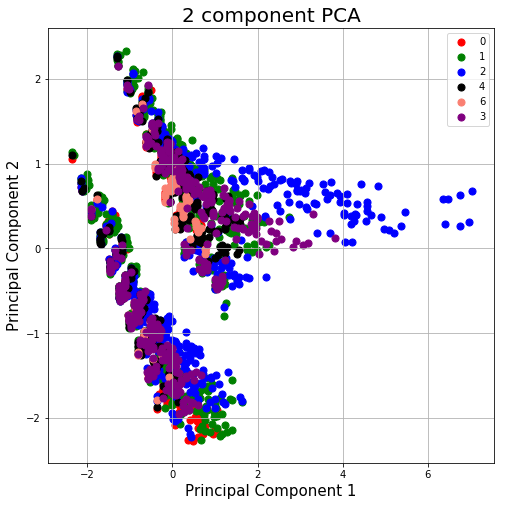

In [13]:
features = ['cuantos', 'edad', 'edo_civil', 'hora', 'mes']
x = c.loc[:, features].values
y = c.loc[:,['escolaridad']].values
x = StandardScaler().fit_transform(x)

pca = PCA(n_components = 2)
cd = pd.DataFrame(data = pca.fit_transform(x), columns = ['comp_{:d}'.format(i) for i in range(k)])
cd['escolaridad'] = y
display(cd.head(5))

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA', fontsize = 20)

targets = cd.escolaridad.unique()
colors = ['r', 'g', 'b', 'black', 'salmon', 'purple']
for target, color in zip(targets,colors):
    indicesToKeep = cd['escolaridad'] == target
    ax.scatter(cd.loc[indicesToKeep, 'comp_0']
               , cd.loc[indicesToKeep, 'comp_1']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()
plt.savefig('pca.eps')

La división de los datos podría explicarse por el estado civil, solteros y casados. De cualquier forma no se pueden separar los datos de acuerdo a la escolaridad de la víctima.